# Titanic: Machine Learning from Disaster

### Summary

### Variables Description
<ul>
<li><b>PassengerId</b>: Passenger ID
<li><b>Survived</b>: Survival (0 = No, 1 = Yes)
<li><b>Pclass</b>: Ticket class (1 = First class, 2 = Second class, 3 = Third class)
<li><b>Name</b>: Name of the passenger
<li><b>Sex</b>: Sex of the passenger
<li><b>Age</b>: Age in years
<li><b>SibSp</b>: Number of siblings or spouses on board
<li><b>Parch</b>: Number of parents or children on board
<li><b>Ticket</b>: Ticket number
<li><b>Fare</b>: Passenger fare
<li><b>Cabin</b>: Cabin number
<li><b>Embarked</b>: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

### EDA

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score ,auc, roc_curve
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, neural_network
#import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [3]:
train = pd.read_csv('train.csv')

In [126]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [127]:
train[['Pclass', 'Survived']].groupby(by='Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


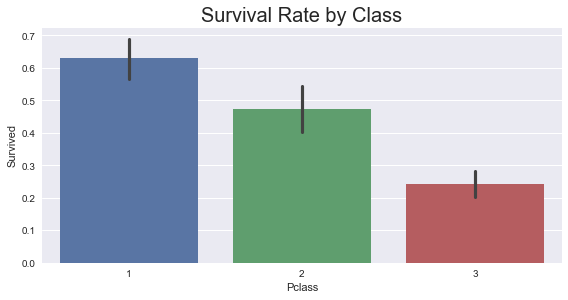

In [105]:
sns.factorplot(y='Survived', x='Pclass', data=train, kind='bar', aspect=2)
plt.title('Survival Rate by Class', fontsize=20)

In [101]:
train[['Sex', 'Survived']].groupby(by='Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


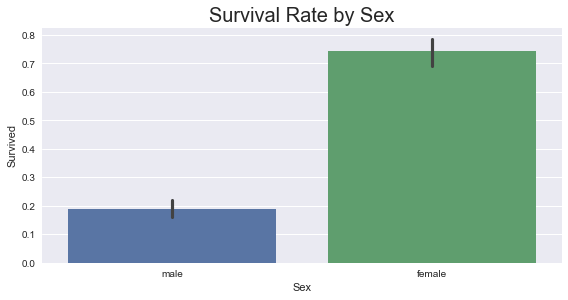

In [104]:
sns.factorplot(y='Survived', x='Sex', data=train, kind='bar', aspect=2)
plt.title('Survival Rate by Sex', fontsize=20)

In [107]:
train[['Embarked', 'Survived']].groupby(by='Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


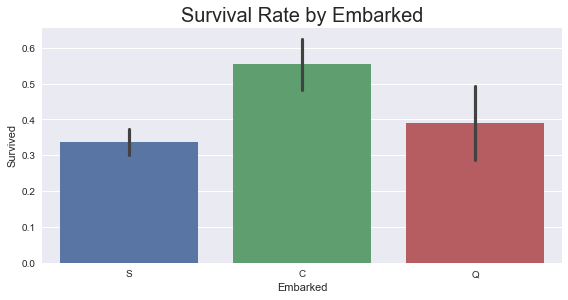

In [113]:
sns.factorplot(y='Survived', x='Embarked', data=train, kind='bar', aspect=2)
plt.title('Survival Rate by Embarked', fontsize=20)

### Cleaning

### Feature Engineering

#### Train

In [3]:
#Drop name, drop cabin, drop ticket, drop ID, fill age with median, combine sibsp with parch
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
train = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1) #drop the columns that we dont want

In [5]:
train['Age'] = train.Age.fillna(train.Age.median()) #fill na in age with age median
train['AgeBand'] = pd.cut(train.Age, 5)
train[['Survived', 'AgeBand']].groupby(by='AgeBand').mean()

,Survived
AgeBand,
"(0.34, 16.336]",0.550000
"(16.336, 32.252]",0.344168
"(32.252, 48.168]",0.404255
"(48.168, 64.084]",0.434783
"(64.084, 80.0]",0.090909


In [6]:
train['Age'] = pd.cut(train.Age, 5, labels=False)
train = train.drop('AgeBand', axis=1)

In [7]:
train['Sex'] = pd.get_dummies(train['Sex'], drop_first=True).astype('int') #change sex to 1(male) and 0(female)

In [8]:
train['Family'] = train.SibSp + train.Parch #combine the number of sib and the number of parch
train = train.drop(['SibSp', 'Parch'], axis=1)

In [9]:
Embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
train['Embarked'] = train['Embarked'].fillna(train.Embarked.mode()[0]).map(Embarked_mapping)

In [10]:
train['FareBand'] = pd.cut(train.Fare, 4)
train[['Survived', 'FareBand']].groupby(by='FareBand').mean()

,Survived
FareBand,
"(-0.512, 128.082]",0.368113
"(128.082, 256.165]",0.724138
"(256.165, 384.247]",0.666667
"(384.247, 512.329]",1.000000


In [11]:
train['Fare'] = pd.cut(train.Fare, 4, labels=False)
train = train.drop('FareBand', axis=1)

### Machine Learning

Logistic regression, KNN, SVM, Naive Bayes, Decision tree, Random forest, LDA & QDA, MLP(neural network), xgboost

In [35]:
X_train_O = train.drop('Survived', axis=1)
Y_train_O = train.Survived
X_train, X_test, Y_train, Y_test = train_test_split(X_train_O, Y_train_O, test_size=0.2, random_state=3)

In [42]:
MLA = [
    linear_model.LogisticRegressionCV(),
    neighbors.KNeighborsClassifier(3),
    svm.SVC(gamma=2, C=1),
    naive_bayes.GaussianNB(),
    tree.DecisionTreeClassifier(max_depth=3),
    ensemble.RandomForestClassifier(max_depth=3, n_estimators=10, max_features=1),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    discriminant_analysis.LinearDiscriminantAnalysis(),
    neural_network.MLPClassifier(alpha=1)
]

In [43]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for alg in MLA:
    predicted = alg.fit(X_train, Y_train).predict(X_test)
    fp, tp, th = roc_curve(Y_test, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'Precision'] = precision_score(Y_test, predicted)
    MLA_compare.loc[row_index, 'AUC'] = auc(fp, tp)
    
    row_index+=1
MLA_compare.sort_values(by = ['AUC'], ascending = False, inplace = True)
MLA_compare

,MLA Name,Precision,AUC
8,MLPClassifier,0.728571,0.777130
4,DecisionTreeClassifier,0.793103,0.773526
0,LogisticRegressionCV,0.688312,0.768480
7,LinearDiscriminantAnalysis,0.693333,0.765924
2,SVC,0.738462,0.764875
3,GaussianNB,0.710145,0.758257
6,QuadraticDiscriminantAnalysis,0.701493,0.743971
5,RandomForestClassifier,0.725806,0.743447
1,KNeighborsClassifier,0.626667,0.707274


### Comparison

In [64]:
#save it for later
train[['Pclass', 'Male', 'Age']].groupby(by=['Pclass', 'Male']).median()

Age
Pclass Male      
1      0     35.0
       1     40.0
2      0     28.0
       1     30.0
3      0     21.5
       1     25.0

In [69]:
#save it for later
for age in train.Age:
    if age == 'NaN':
        if train.Pclass == 1 & train.Male == 0:
            train.Age['age'] == 35.0
        elif train.Pclass == 1 & train.Male == 1:
            train.Age['age'] == 40.0
        elif train.Pclass == 2 & train.Male == 0:
            train.Age['age'] == 28.0
        elif train.Pclass == 2 & train.Male == 1:
            train.Age['age'] == 30.0
        elif train.Pclass == 3 & train.Male == 0:
            train.Age['age'] == 21.5
        elif train.Pclass == 3 & train.Male == 1:
            train.Age['age'] == 25.0
    else:
        age